<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/Class_03_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q condacolab
!git clone --single-branch --branch cecam https://github.com/cmelab/hoomd-organics
import condacolab
condacolab.install()

Cloning into 'hoomd-organics'...
remote: Enumerating objects: 3573, done.
remote: Counting objects: 100% (890/890), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 3573 (delta 735), reused 706 (delta 706), pack-reused 2683 (from 1)
Receiving objects: 100% (3573/3573), 1.53 MiB | 5.13 MiB/s, done.
Resolving deltas: 100% (2462/2462), done.
✨🍰✨ Everything looks OK!


In [3]:
#!pip install --upgrade ipykernel #breaks things?
import os
os.chdir("hoomd-organics")
!mamba env update -n base -f environment-cpu.yml
!python -m pip install -e .
import warnings
warnings.filterwarnings('ignore')

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



cudatoolkit-11.8.0   | 682.5 MB  | :   0% 0/1 [00:00<?, ?it/s]
gcc_impl_linux-64-14 | 70.1 MB   | :   0% 0/1 [00:00<?, ?it/s]

pillow-11.1.0        | 40.1 MB   | :   0% 0/1 [00:00<?, ?it/s]


libllvm14-14.0.6     | 30.0 MB   | :   0% 0/1 [00:00<?, ?it/s]



libflint-3.1.3.1     | 20.2 MB   | :   0% 0/1 [00:00<?, ?it/s]




rdkit-2024.09.6      | 19.0 MB   | :   0% 0/1 [00:00<?, ?it/s]





parmed-4.3.0         | 18.5 MB   | :   0% 0/1 [00:00<?, ?it/s]






scipy-1.15.2         | 16.4 MB   | :   0% 0/1 [00:00<?, ?it/s]







libclang-cpp14-14.0. | 15.8 MB   | :   0% 0/1 [00:00<?, ?it/s]








pandas-2.2.3         | 15.0 MB   | :   0% 0/1 [00:00<?, ?it/s]









sysroot_linux-64-2.

In [6]:
import hoomd
import matplotlib
import numpy

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [8]:
integrator = hoomd.md.Integrator(dt=0.005)

In [9]:
integrator.dt

0.005

In [11]:
integrator.forces[:]

[]

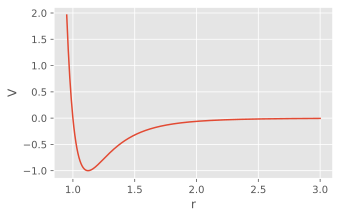

In [12]:
sigma = 1
epsilon = 1
r = numpy.linspace(0.95,3,500)
V_lj = 4 * epsilon * ((sigma/r) ** 12 - (sigma/r) ** 6)

fig = matplotlib.figure.Figure(figsize=(5,3.09))
ax = fig.add_subplot()
ax.plot(r, V_lj)
ax.set_xlabel("r")
ax.set_ylabel("V")
fig

In [13]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

In [14]:
lj = hoomd.md.pair.LJ(nlist=cell)

In [15]:
lj.params[("A","A")] = dict(epsilon=1,sigma=2)
lj.r_cut[("A","A")] = 2.5

In [16]:
integrator.forces.append(lj)

In [26]:
nvt = hoomd.md.methods.NVT(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)

AttributeError: module 'hoomd.md.methods' has no attribute 'thermostats'

In [38]:
import numpy
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)

In [39]:
kT = 1.0
epsilon = 1.0
sigma = 1.0
final_density = 1.0

In [40]:
import freud
starting_density = 0.5
a = 1/(starting_density**(1/3.0))
num_replicas = 10
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx

In [41]:
import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

frame.particles.typeid = [0]*N_particles # N_partiles-long list of 0
frame.particles.types = ['A']

with gsd.hoomd.open(name='initial_state.gsd',mode='w') as f:
  f.append(frame)

In [42]:
simulation.create_state_from_gsd(filename='initial_state.gsd')

In [43]:
integrator = hoomd.md.Integrator(dt=0.005)
nve = hoomd.md.methods.NVE(filter = hoomd.filter.All())
integrator.methods.append(nve)

In [44]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

lj = hoomd.md.pair.LJ(nlist=cell)

lj.params[('A','A')] = {'epsilon':epsilon,'sigma':sigma}

lj.r_cut[('A','A')] = 2.5*sigma

integrator.forces.append(lj)
simulation.operations.integrator = integrator

In [45]:
simulation.run(100)

In [46]:
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(),kT=1.0)

thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

simulation.operations.computes.append(thermodynamic_properties)

logger = hoomd.logging.Logger(categories=['scalar','sequence'])
logger.add(simulation)
logger.add(thermodynamic_properties)

tps_tracking = hoomd.logging.Logger(categories=['scalar','string'])
tps_tracking.add(simulation,quantities=['timestep','tps'])

table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)),logger=tps_tracking) # need to finish this line
simulation.operations.writers.append(table)

In [47]:
simulation.run(1e5)

Simulation.timestep  Simulation.tps 
       10000           875.17010    
       20000           885.06840    
       30000           878.58026    
       40000           873.77339    
       50000           870.79878    
       60000           868.32972    
       70000           867.32913    
       80000           864.70086    
       90000           864.00901    
      100000           863.39895    
